In [1]:
import sys, os
import matplotlib.pyplot as plt
import glob, cv2, time
import numpy as np

from scipy.misc import imresize, imsave

%matplotlib inline

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as k

from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


Using TensorFlow backend.
Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
train_path ='./wbc_segmentation/Data/Train_Data/' #path of training images 
test_path = './wbc_segmentation/Data/Test_Data/' # path of testing images
pred_path = 'preds' # path for storing predicted masks

1. Load Training data
2. Resize images to 96 * 96



In [3]:
img_rows = 96
img_cols = 96

smooth =1.


def process_img(img_file):
    "resize image"
    img = cv2.imread(img_file)
    img = (cv2.resize(img,(img_rows, img_cols)).astype('uint8'))

    return img

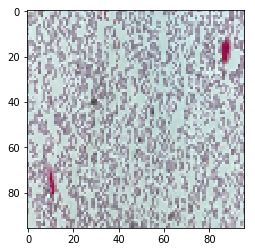

In [4]:
file = './wbc_segmentation/Data/Train_Data/017532875DDF.jpg'

processed_img = process_img(file)
plt.imshow(processed_img)

In [5]:
def load_training_data():
    start = time.time()
    train_id = []
    train_img = []
    train_mask_img = []
    
    print('-'*30)
    print('Loading training data...')
    print('-'*30)
    
    path = train_path+'*.jpg'
    files = glob.glob(path)
    for im_file in files:
        
        if 'mask' in im_file:
            img_id =  os.path.basename(im_file).split('-mask.jpg')[0]
            train_id.append(img_id)
            img_mask = process_img(im_file)
            #img_mask = img_mask.astype('float32')
            train_mask_img.append(img_mask[:,:,1])
            orig_img_path = os.path.splitext(img_id)[0]+'.jpg'
            orig_img = process_img(train_path + orig_img_path)
            #orig_img = orig_img.astype('float32')
            train_img.append(orig_img[:,:,1])
    
    end = time.time() - start
    print("Number of training examples : %4r" % (len(train_img)))
    print("Time: % 2f seconds " % end)
    X_train = np.asarray(train_img)
    y_train = np.asarray(train_mask_img)
    X_train = X_train.astype('float32') * (1. / 255) -0.5
    y_train = y_train.astype('float32') * (1. / 255)
    
    return X_train, y_train, train_id

In [6]:
X_train, y_train, train_id = load_training_data()
print(X_train[0].shape)

------------------------------
Loading training data...
------------------------------
Number of training examples :  169
Time:  0.164791 seconds 
(96, 96)


In [7]:
def load_testing_data():
    start = time.time()
    test_img = []
    test_id = []
    
    print('-'*30)
    print('Load testing data...')
    print('-'*30)
    
    path = test_path + '*.jpg'
    files = glob.glob(path)
    for im_file in files:
        img = process_img(im_file)
        test_img.append(img[:,:,1])
        test_id.append(os.path.basename(im_file).split('.jpg')[0])
    end = time.time() - start
    
    print("Number of testing examples : %4r" % (len(test_img)))
    print("Time: %2f seconds " % end)
    test_img = np.asarray(test_img)
    test_img = test_img.astype('float32') * (1. / 255) -0.5
    return test_id, test_img

In [8]:
test_id, test_img_orignal = load_testing_data()
print(len(test_id), len (test_img_orignal))
test_img = test_img_orignal

------------------------------
Load testing data...
------------------------------
Number of testing examples :   61
Time: 0.276266 seconds 
61 61


In [9]:
def visualize(X_img,y_img,idx):
    """ Displays a training image and the mask."""
    if (idx > 0):
        im = X_img[idx]
        plt.subplot(1,2,1)
        plt.imshow(im)

        im_mask = y_img[idx]
        plt.subplot(1,2,2)
        plt.imshow(im_mask)
    else:
        for i in range(len(X_img)):
            im = X_img[i]
            plt.figure()
            plt.subplot(1,2,1)
            plt.imshow(im)
            
            im_mask = y_img[i]
            plt.subplot(1,2,2)
            plt.imshow(im_mask)

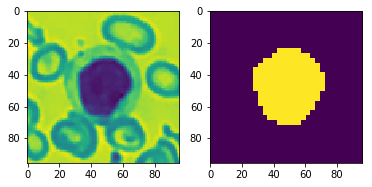

In [10]:
visualize(X_train,y_train, idx=3)

In [11]:
def dice_coef(y_true,y_pred):
    y_true_f = k.flatten(y_true)
    y_pred_f = k.flatten(y_pred)
    intersection = k.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (k.sum(y_true_f) + k.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [12]:
def get_unet():
    inputs = Input((img_rows,img_cols,1))
    conv1 = Conv2D(32,(3,3), activation='relu', padding = 'same')(inputs)
    conv1 = Conv2D(32,(3,3), activation='relu', padding = 'same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
    
    conv2 = Conv2D(64,(3,3), activation='relu',padding = 'same')(pool1)
    conv2 = Conv2D(64,(3,3), activation='relu',padding = 'same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
    
    conv3 = Conv2D(128,(3,3), activation='relu',padding = 'same')(pool2)
    conv3 = Conv2D(128,(3,3), activation='relu',padding = 'same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
    
    conv4 = Conv2D(256,(3,3), activation='relu',padding = 'same')(pool3)
    conv4 = Conv2D(256,(3,3), activation='relu',padding = 'same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2,2))(conv4)
    
    conv5 = Conv2D(512,(3,3), activation='relu',padding = 'same')(pool4)
    conv5 = Conv2D(512,(3,3), activation='relu',padding = 'same')(conv5)
    
    up6 = concatenate([Conv2DTranspose(256,(2,2),strides=(2,2), padding='same')(conv5),(conv4)],axis=3)
    conv6 = Conv2D(256,(3,3),activation='relu',padding='same')(up6)
    conv6 = Conv2D(256,(3,3),activation='relu',padding='same')(conv6)
    
    up7 = concatenate([Conv2DTranspose(128,(2,2),strides=(2,2), padding='same')(conv6),(conv3)],axis=3)
    conv7 = Conv2D(128,(3,3),activation='relu',padding='same')(up7)
    conv7 = Conv2D(128,(3,3),activation='relu',padding='same')(conv7)
    
    up8 = concatenate([Conv2DTranspose(64,(2,2),strides=(2,2), padding='same')(conv7),(conv2)],axis=3)
    conv8 = Conv2D(64,(3,3),activation='relu',padding='same')(up8)
    conv8 = Conv2D(64,(3,3),activation='relu',padding='same')(conv8)
    
    up9 = concatenate([Conv2DTranspose(32,(2,2),strides=(2,2), padding='same')(conv8),(conv1)],axis=3)
    conv9 = Conv2D(32,(3,3),activation='relu',padding='same')(up9)
    conv9 = Conv2D(32,(3,3),activation='relu',padding='same')(conv9)
    
    conv10 = Conv2D(1,(1,1),activation='relu',padding='same')(conv9)
    
    model = Model(input=[inputs],output=[conv10])
    
    model.compile(optimizer=Adam(lr=1e-5),loss=dice_coef,metrics=[dice_coef_loss])
    
    
    
    return model

In [13]:
def train_and_predict():
    print('-'*30)
    print('Loading and preprocessing train data...')
    print('-'*30)

    imgs_train, imgs_mask_train, train_id = load_training_data()
    
    print('imgs_train:',len(imgs_train),len(imgs_mask_train))
    
    print('img_train_shape: ', imgs_train[0].shape)
    
    imgs_train_p = np.ndarray((imgs_train.shape[0],img_rows,img_cols),dtype= np.uint8)
    for i in range(imgs_train.shape[0]):
        imgs_train_p[i] = imresize(imgs_train[i],(img_cols,img_rows))
        #imgs_train_p[i] = tf.reshape(imgs_train[i],(img_cols,img_rows,1))
    imgs_train_p = imgs_train_p[...,np.newaxis]
    
    
    imgs_mask_train_p = np.ndarray((imgs_mask_train.shape[0],img_rows,img_cols),dtype=np.uint8)
    for i in range(imgs_mask_train.shape[0]):
        imgs_mask_train_p[i] = imresize(imgs_mask_train[i],(img_cols,img_rows))
    imgs_mask_train_p = imgs_mask_train_p[...,np.newaxis]
    
     
    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    
    model = get_unet()
    
    model.summary()
    plot_model(model,to_file='model.png')
    
    SVG(model_to_dot(model).create(prog = 'dot',format = 'svg'))
    
    model_checkpoint = ModelCheckpoint('./weights.h5',monitor='val_loss',save_best_only=True)
    
    model.save_weights("model.h5")
    print('-'*30)
    print('Saved model to disk.')
    print('-'*30)
    
    print('-'*30)
    print('Fitting model...')
    print('-'*30)
    model.fit(imgs_train_p,imgs_mask_train_p,batch_size=32,nb_epoch=20,verbose=1,shuffle=True,
             validation_split=0.2,
             callbacks=[model_checkpoint])
    
    print('-'*30)
    print('Loading and processing test data...')
    print('-'*30)
    
    imgs_id_test, imgs_test = load_testing_data()
        
    imgs_test_p = np.ndarray((imgs_test.shape[0],img_rows,img_cols),dtype=np.uint8)
    for i in range(imgs_test.shape[0]):
        imgs_test_p[i] = imresize(imgs_test[i],(img_cols,img_rows))
    imgs_test_p = imgs_test_p[...,np.newaxis]
    
    print('-'*30)
    print('Loading saved weights...')
    print('-'*30)
    model.load_weights("weights.h5")
    
    print('-'*30)
    print('Predicting masks on test data...')
    print('-'*30)
    print('total test images: ',len(imgs_test_p))
    
    imgs_mask_test = model.predict(imgs_test_p,verbose=1)
    
    print('total predicted images: ',len(imgs_mask_test))
    np.save('imgs_mask_test.npy',imgs_mask_test)
    
    print('-'*30)
    print('Saving predicting masks to files...')
    print('-'*30)
    pred_dir = 'preds'
    if not os.path.exists(pred_dir):
        os.mkdir(pred_dir)
    for image, img_id in zip(imgs_test_p, imgs_id_test):
        image = (image[:,:,0]*255.).astype(np.uint8)
        path = os.path.join(test_path + img_id + '.jpg')
        
        orig_img_test = cv2.imread(path )
    
        image = imresize(image,(orig_img_test.shape[0],orig_img_test.shape[1]))
        ret,thresh1 = cv2.threshold(image,180,255,cv2.THRESH_BINARY)
        imsave(os.path.join(pred_dir,img_id+'_pred.jpg'),thresh1)

In [14]:
train_and_predict()

------------------------------
Loading and preprocessing train data...
------------------------------
------------------------------
Loading training data...
------------------------------
Number of training examples :  169
Time:  0.158677 seconds 
imgs_train: 169 169
img_train_shape:  (96, 96)
------------------------------
Creating and compiling model...
------------------------------


/home/gkbell/anaconda3/envs/Unet/lib/python3.5/site-packages/ipykernel/__main__.py:40: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 96, 96, 1)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 96, 96, 32)    320         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 96, 96, 32)    9248        conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 48, 48, 32)    0           conv2d_2[0][0]                   
___________________________________________________________________________________________

/home/gkbell/anaconda3/envs/Unet/lib/python3.5/site-packages/ipykernel/__main__.py:48: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 135 samples, validate on 34 samples
Epoch 1/20
135/135 [==============================] - 32s - loss: 1.6217 - dice_coef_loss: -1.6217 - val_loss: 1.2024 - val_dice_coef_loss: -1.2024
Epoch 2/20
135/135 [==============================] - 33s - loss: 1.0709 - dice_coef_loss: -1.0709 - val_loss: 0.7368 - val_dice_coef_loss: -0.7368
Epoch 3/20
135/

/home/gkbell/anaconda3/envs/Unet/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


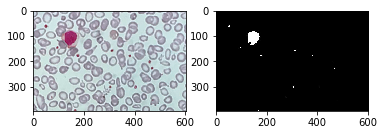

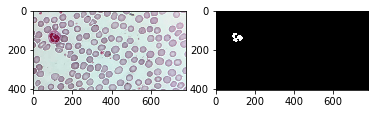

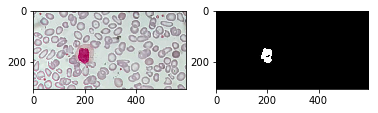

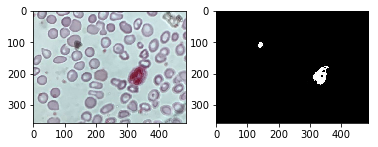

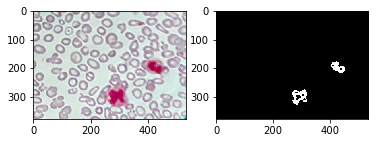

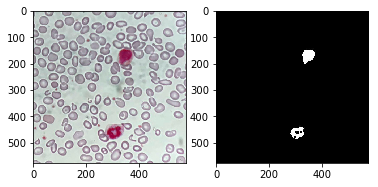

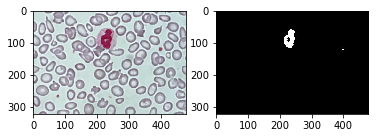

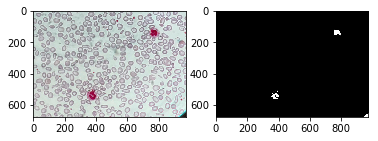

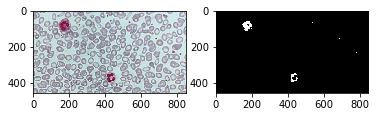

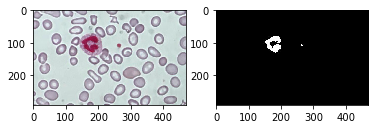

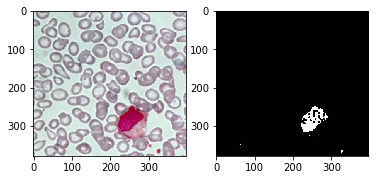

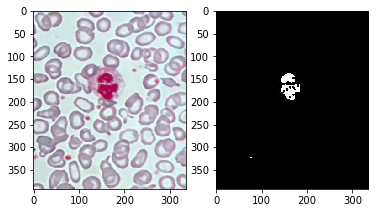

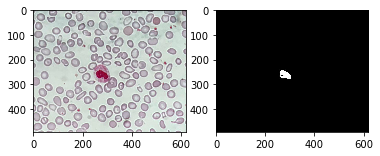

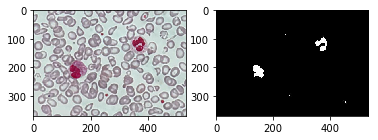

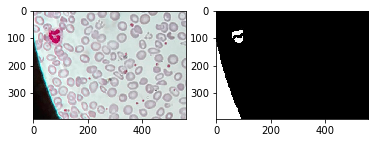

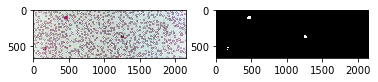

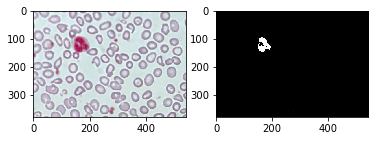

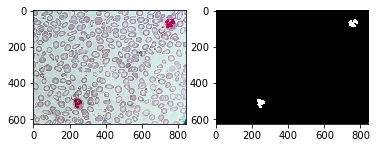

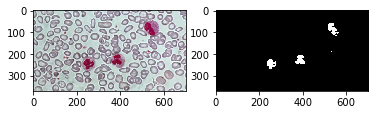

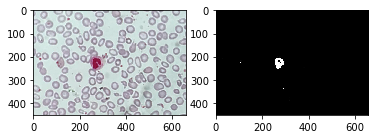

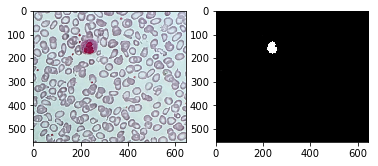

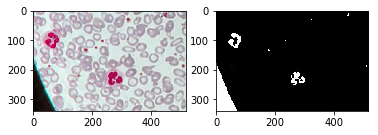

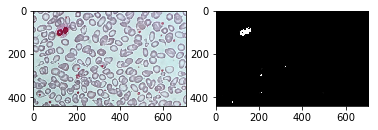

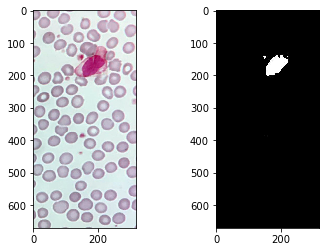

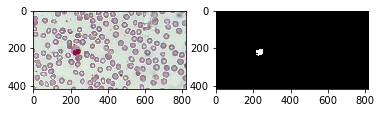

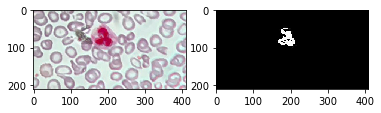

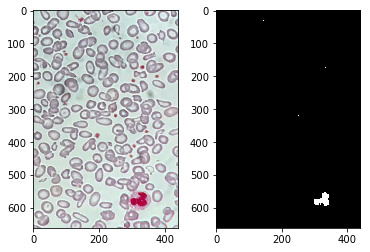

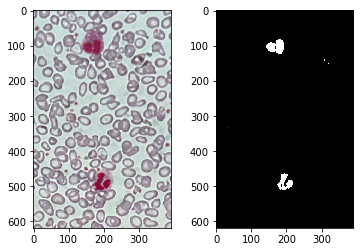

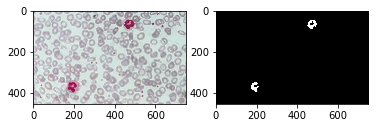

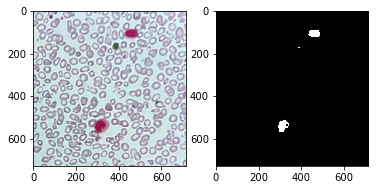

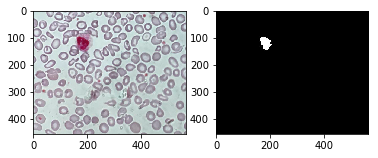

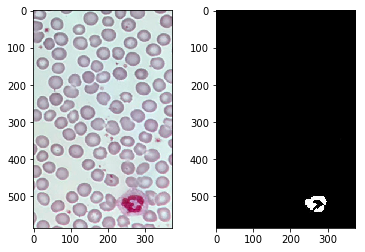

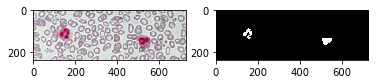

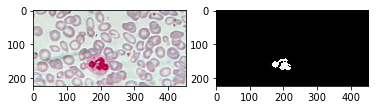

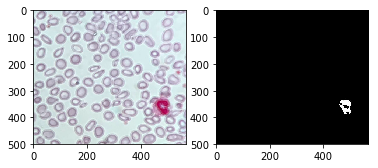

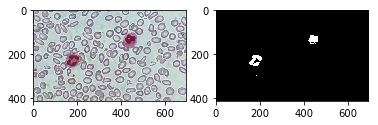

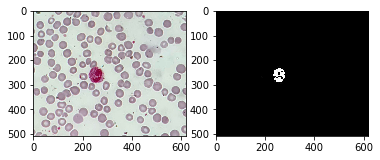

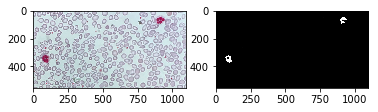

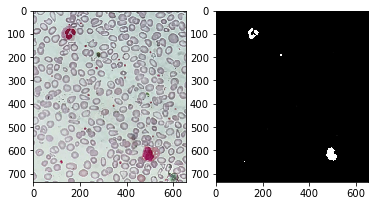

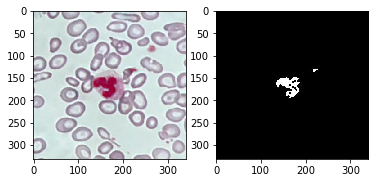

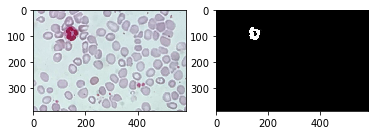

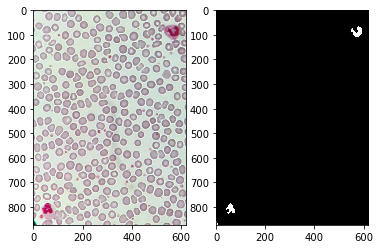

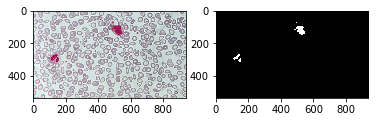

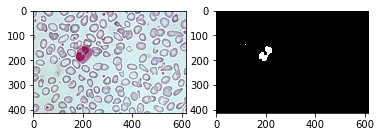

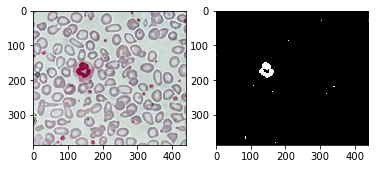

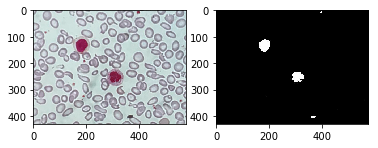

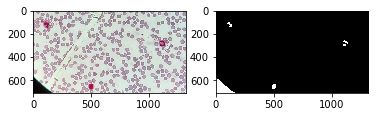

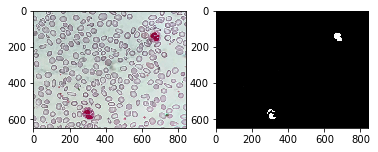

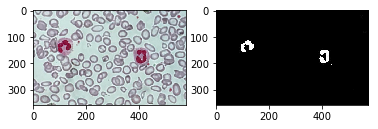

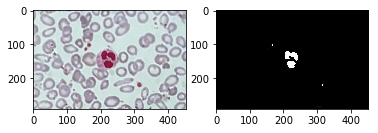

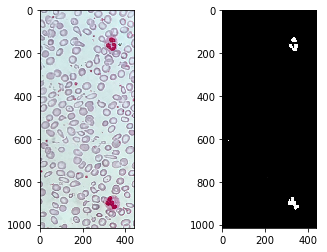

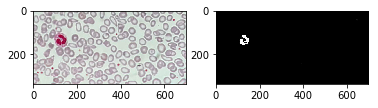

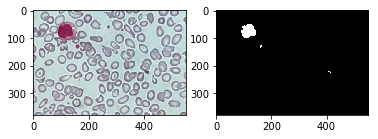

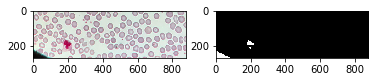

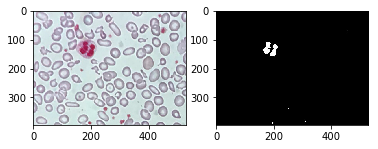

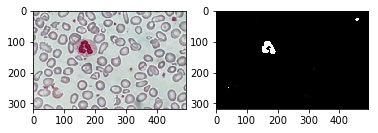

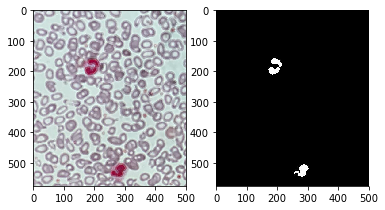

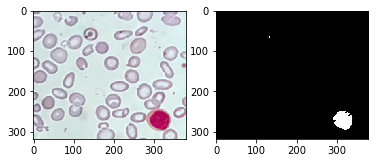

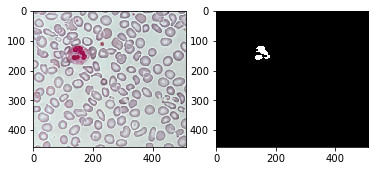

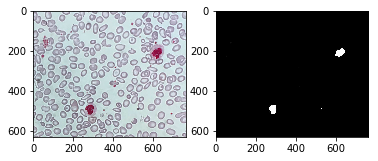

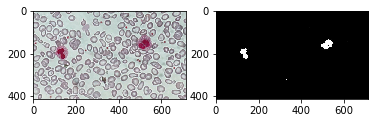

In [15]:
path = test_path + '*.jpg'
test_orig_img = []
files = glob.glob(path)
for file in files:
    test_orig_img.append(cv2.imread(file))
    
pred_mask = []
for file in files:
    img_id = os.path.basename(file).split('.jpg')[0]
    pred_mask.append(cv2.imread(os.path.join(pred_path,img_id+'_pred.jpg')))
    
visualize(X_img=test_orig_img, y_img=pred_mask,idx=0)